In [123]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# encodage des mots en Int
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense , merge
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import ReduceLROnPlateau


from keras.layers.merge import dot
from keras.models import Model


# specifically for deeplearning.
from keras.layers import Dropout, Flatten,Activation,Input,Embedding
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import tensorflow as tf
import random as rn
from IPython.display import SVG
 
# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
#import cv2 # erreur import
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

#TL pecific modules
from keras.applications.vgg16 import VGG16

# pour parser le fichier train.json
import json

In [124]:
with open('../input/whats-cooking/train.json', 'r') as f:
    datas = json.load(f) # id, cuisine, ingredients[]

csv = []
occurence = dict()
for data in datas:
    for ingredient in data['ingredients']:
        cuisine = data['cuisine']
        
        # Ajout de la ligne id-cuisine-ingredient
        tmp = dict()
        tmp['id'] = str(data['id'])
        tmp['cuisine'] = cuisine
        tmp['ingredient'] = ingredient
        csv.append(tmp)
        
        # Comptage de l'occurence
        if not cuisine in occurence:
            occurence[cuisine] = dict()
        if not ingredient in occurence[cuisine]:
            occurence[cuisine][ingredient] = 0
        occurence[cuisine][ingredient] += 1

# Ajout des occurences dans le CSV
for ligne in csv:
    cuisine = ligne['cuisine']
    ingredient = ligne['ingredient']
    ligne['occurence'] = occurence[cuisine][ingredient]


# $ingredients contient tous les ingredients possibles


train = pd.DataFrame(csv)

In [125]:
df = train.copy()

In [126]:
df.head()

,id,cuisine,ingredient,occurence
0,10259,greek,romaine lettuce,39
1,10259,greek,black olives,31
2,10259,greek,grape tomatoes,26
3,10259,greek,garlic,216
4,10259,greek,pepper,203


In [103]:
# Encodage des valeurs

#le_cuisine = LabelEncoder()
#le_ingredient = LabelEncoder()

#df['cuisine'] = le_cuisine.fit_transform(df['cuisine'])
#df['ingredient'] = le_ingredient.fit_transform(df['ingredient'])

# Pour inverser l'encodage il faudra utiliser ces deux lignes :
#df['cuisine'] = le_cuisine.inverse_transform(df['cuisine'])
#df['ingredient'] = le_ingredient.inverse_transform(df['ingredient'])

#df.head()

In [ ]:
df['cuisine'].unique()

In [117]:
len(df['cuisine'].unique())

20

In [ ]:
df['ingredient'].unique()

In [ ]:
len(df['ingredient'].unique())

In [ ]:
# Pour verifier que toutes les donnees sont bonnes
df['cuisine'].isnull().sum()

In [ ]:
# Pour verifier que toutes les donnees sont bonnes
df['ingredient'].isnull().sum()

In [127]:
# Creation de la matrix

index = list(df['cuisine'].unique())
columns = list(df['ingredient'].unique())
index = sorted(index)
columns = sorted(columns)
 
util_df = pd.pivot_table(data = df, values = 'occurence', index = 'cuisine', columns = 'ingredient')

In [128]:
util_df

ingredient,( oz.) tomato sauce,( oz.) tomato paste,(10 oz.) frozen chopped spinach,"(10 oz.) frozen chopped spinach, thawed and squeezed dry",(14 oz.) sweetened condensed milk,(14.5 oz.) diced tomatoes,(15 oz.) refried beans,1% low-fat buttermilk,1% low-fat chocolate milk,1% low-fat cottage cheese,...,yukon gold potatoes,yuzu,yuzu juice,za'atar,zest,zesty italian dressing,zinfandel,ziti,zucchini,zucchini blossoms
cuisine,,,,,,,,,,,,,,,,,,,,,
brazilian,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
british,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
cajun_creole,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,NaN
chinese,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,30.0,NaN
filipino,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN
french,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,...,41.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,86.0,NaN
greek,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,2.0,1.0,2.0,3.0,47.0,NaN
indian,NaN,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.0,NaN
irish,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,...,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN


In [130]:
util_df = util_df.fillna(0)

In [143]:
#X = np.array([[1, 1], [2, 1], [3, 1.2], [4, 1], [5, 0.8], [6, 1]])
X = util_df
from sklearn.decomposition import NMF
model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(X)
H = model.components_

In [144]:
print(W)
print(len(W), len(W[0]))

[[ 0.25861121  0.58085159]
 [ 0.13238621  1.61153323]
 [ 0.81031534  2.87846476]
 [ 2.0403599   1.48667072]
 [ 0.60869855  0.91418252]
 [ 0.10120908  6.29224064]
 [ 0.20558513  2.88698735]
 [ 3.56234636  1.55085553]
 [ 0.14207163  1.36574611]
 [ 0.         21.91773592]
 [ 0.4312188   0.72751495]
 [ 0.79067905  0.76283801]
 [ 0.65158201  0.53385564]
 [ 7.96960878  0.        ]
 [ 0.57639004  1.48505349]
 [ 0.19524352  0.95633462]
 [ 1.03692007  8.48430281]
 [ 0.29028605  2.21649753]
 [ 1.29180602  0.28222918]
 [ 0.66644867  0.43327124]]
20 2


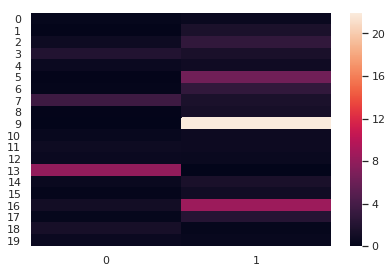

In [146]:
import seaborn as sns
# reconvertir ax en dataFrame pour remettre les nom de cuisine
ax = sns.heatmap(W)
ax.pivot = util_df

In [120]:
print(H)
print(len(H), len(H[0]))

[[ 0.0413363   0.32009222  0.         ...  0.         13.75283058
   0.08286734]
 [ 0.25745358  0.13136452  0.10461423 ...  0.92043636 12.58249348
   0.0314914 ]]
2 6714


In [ ]:
ingredients = df.ingredient.unique()
cuisines = df.cuisine.unique()

ingredient2idx = {o:i for i,o in enumerate(ingredients)}
cuisine2idx = {o:i for i,o in enumerate(cuisines)}

In [ ]:
df['ingredient'] = df['ingredient'].apply(lambda x: ingredient2idx[x])
df['cuisine'] = df['cuisine'].apply(lambda x: cuisine2idx[x])
split = np.random.rand(len(df)) < 0.8
train = df[split]
valid = df[~split]
print(train.shape , valid.shape)

In [ ]:
n_ingredients=len(df['ingredient'].unique())
n_cuisines=len(df['cuisine'].unique())
n_latent_factors=64  # hyperparamter to deal with. 

In [ ]:
cuisine_input=Input(shape=(1,),name='cuisine_input',dtype='int64')

In [ ]:
cuisine_embedding=Embedding(n_cuisines,n_latent_factors,name='cuisine_embedding')(cuisine_input)
#cuisine_embedding.shape

In [ ]:
cuisine_vec =Flatten(name='FlattenCuisines')(cuisine_embedding)
#cuisine_vec.shape

In [ ]:
ingredient_input=Input(shape=(1,),name='ingredient_input',dtype='int64')
ingredient_embedding=Embedding(n_ingredients,n_latent_factors,name='ingredient_embedding')(ingredient_input)
ingredient_vec=Flatten(name='FlattenIngredients')(ingredient_embedding)
#ingredient_vec

In [ ]:
sim=dot([cuisine_vec,ingredient_vec],name='Simalarity-Dot-Product',axes=1)
model =keras.models.Model([cuisine_input, ingredient_input],sim)
# #model.summary()
# # A summary of the model is shown below-->

In [ ]:
model.compile(optimizer=Adam(lr=1e-4),loss='mse')

In [ ]:
train.shape
batch_size=128
epochs=50

In [ ]:
History = model.fit([train.cuisine,train.ingredient], train.occurence, batch_size=batch_size, epochs =epochs, validation_data = ([valid.cuisine,valid.ingredient],valid.occurence), verbose = 1)

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(History.history['loss'] , 'g')
plt.plot(History.history['val_loss'] , 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
n_latent_factors=50
n_ingredients=len(df['ingredient'].unique())
n_cuisines=len(df['cuisine'].unique())

In [ ]:
# user=cuisine, movie=ingredient
cuisine_input=Input(shape=(1,),name='cuisine_input',dtype='int64')
cuisine_embedding=Embedding(n_cuisines,n_latent_factors,name='cuisine_embedding')(cuisine_input)
cuisine_vec=Flatten(name='FlattenCuisines')(cuisine_embedding)
cuisine_vec=Dropout(0.40)(cuisine_vec)

In [ ]:
ingredient_input=Input(shape=(1,),name='ingredient_input',dtype='int64')
ingredient_embedding=Embedding(n_ingredients,n_latent_factors,name='ingredient_embedding')(ingredient_input)
ingredient_vec=Flatten(name='FlattenMovies')(ingredient_embedding)
ingredient_vec=Dropout(0.40)(ingredient_vec)

In [ ]:
sim=dot([cuisine_vec,ingredient_vec],name='Simalarity-Dot-Product',axes=1)

In [ ]:
nn_inp=Dense(96,activation='relu')(sim)
nn_inp=Dropout(0.4)(nn_inp)
# nn_inp=BatchNormalization()(nn_inp)
nn_inp=Dense(1,activation='relu')(nn_inp)
nn_model =keras.models.Model([cuisine_input, ingredient_input],nn_inp)
nn_model.summary()

In [ ]:
nn_model.compile(optimizer=Adam(lr=1e-3),loss='mse')

In [ ]:
batch_size=128
epochs=20

In [ ]:
# user=cuisine, movie=ingredient
History = nn_model.fit([train.cuisine,train.ingredient],train.occurence, batch_size=batch_size,
                              epochs =epochs, validation_data = ([valid.cuisine,valid.ingredient],
                              valid.occurence), verbose = 1)

In [ ]:
rcParams['figure.figsize'] = 10, 5
plt.plot(History.history['loss'] , 'g')
plt.plot(History.history['val_loss'] , 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()